<H1>Predicción de Ausencia de Paciente a su Cita Medica </H1>

<H2>Comparación de distintas caracteristicas y Algoritmos (XGBoost)</H2>

El ejemplo esta basado en 100 000 Citas medicas de una región (Vitória, Espírito Santo) de Brazil.
En base a caracteristicas demograficas, sociales y de enfermedades cronicas del paciente, se intenta determinar su presencia/ausencia en la cita programada.

En este ejemplo se comparan lo resultados obtenidos previamente con otro algoritmo:
<ul>
    <li><em>ABT con 11 caracteristicas y Regression Logistica</em></li>
    <li><em>ABT con 110 caracteristicas y Regression Logistica</em></li>
    <li><em>ABT con 11 caracteristicas y XGBoost</em></li>
</ul>


<H2>Carga de Librerias Python</H2>

In [1]:
#Carga inicial de librerias imprescindibles

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#import seaborn as sns
#sns.set(style="whitegrid", color_codes=True)
%matplotlib inline

#ML imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV

#Pipeline needed for PMML Export
from sklearn.pipeline import Pipeline
from sklearn2pmml import PMMLPipeline
from sklearn2pmml import make_pmml_pipeline
from sklearn2pmml import sklearn2pmml


from sklearn import metrics
from sklearn.metrics import roc_curve
#from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


<H2>Carga de datos a Pandas Dataframes</H2>

In [2]:
#Connexión jdbc para este ejemplo
import jaydebeapi

In [3]:
cxn=jaydebeapi.connect("com.intersystems.jdbc.IRISDriver","jdbc:IRIS://iris4ml:51773/MLACADEMY",  ["SuperUser", "sys"], "/usr/local/lib/intersystems/intersystems-jdbc-3.1.0.jar")
dataSimple=pd.read_sql('select top 20000 * from PublishedABT.MLSimpleAppointmentsGetfeatures()',cxn)
cxn.close()

In [4]:
cxn=jaydebeapi.connect("com.intersystems.jdbc.IRISDriver","jdbc:IRIS://iris4ml:51773/MLACADEMY",  ["SuperUser", "sys"], "/usr/local/lib/intersystems/intersystems-jdbc-3.1.0.jar")
dataLarge=pd.read_sql('select top 1000 * from PublishedABT.MLAppointmentsGetfeatures()',cxn)
cxn.close()

In [5]:
#Mostrar las primeras filas de resultantes del ABT PublishedABT.MLAppointmentsGetfeatures()
dataSimple.head()

,Age,Alcoholism,Delay,Diabetes,Gender_F,Gender_M,Handicap,Hypertension,Scholarship,noShow,smsReceived
0,62,False,0,False,1,0,0,True,False,False,False
1,56,False,0,False,0,1,0,False,False,False,False
2,62,False,0,False,1,0,0,False,False,False,False
3,8,False,0,False,1,0,0,False,False,False,False
4,56,False,0,True,1,0,0,True,False,False,False


In [6]:
dataLarge.head()
#dataLarge.info(memory_usage='deep')

,Age,Alcoholism,Delay,Diabetes,Gender_F,Gender_M,Handicap,Hypertension,Neighborhood_AEROPORTO,Neighborhood_ANDORINHAS,...,Neighborhood_SAO_JOSE,Neighborhood_SAO_PEDRO,Neighborhood_SEGURANCA_DO_LAR,Neighborhood_SOLON_BORGES,Neighborhood_TABUAZEIRO,Neighborhood_UNIVERSITARIO,Neighborhood_VILA_RUBIM,Scholarship,noShow,smsReceived
0,62,False,0,False,1,0,0,True,0,0,...,0,0,0,0,0,0,0,False,False,False
1,56,False,0,False,0,1,0,False,0,0,...,0,0,0,0,0,0,0,False,False,False
2,62,False,0,False,1,0,0,False,0,0,...,0,0,0,0,0,0,0,False,False,False
3,8,False,0,False,1,0,0,False,0,0,...,0,0,0,0,0,0,0,False,False,False
4,56,False,0,True,1,0,0,True,0,0,...,0,0,0,0,0,0,0,False,False,False


<H2>Algorithmos</H2>

In [7]:
#Extraer nombre de caracterisicas para uso posterior (p.e Arbol de decision XGBoost )
featuresSimple=list(dataSimple.columns)
featuresSimple.remove('noShow')

In [8]:
#Extracción de las Caracteristicas (en X) y del Resultado (columna "noShow" en y) como arrays numpy...
XSimple = dataSimple.loc[:, dataSimple.columns.isin(featuresSimple)].values
ySimple = dataSimple.loc[:, 'noShow'].values

In [9]:
#Extracción de las Caracteristicas (en X) y del Resultado (columna "noShow" en y) como arrays numpy...
XLarge = dataLarge.loc[:, ~dataLarge.columns.isin(['noShow'])].values
yLarge = dataLarge.loc[:, 'noShow'].values

In [10]:
#Se separan los datos (110 000 filas) en 2 conjuntos: Train para entrenar,
# y test para validar los resultados del algoritmo
# 0.2 => 20% para test
XSimple_train, XSimple_test, ySimple_train, ySimple_test = train_test_split(XSimple, ySimple, test_size = 0.2, random_state=42) 

In [11]:
#Se separan los datos (110 000 filas) en 2 conjuntos: Train para entrenar,
# y test para validar los resultados del algoritmo
# 0.2 => 20% para test
XLarge_train, XLarge_test, yLarge_train, yLarge_test = train_test_split(XLarge, yLarge, test_size = 0.2, random_state=42) 

<H3>ABT con 11 caracteristicas y Regression Logistica</H3>

In [12]:
#Entrenamiento del Algoritmo Regresión Logistica, con "cross validation"
model1 = LogisticRegressionCV(n_jobs=-1, cv=10, max_iter=200, scoring = 'f1', multi_class='ovr')
model1.fit(XSimple_train, ySimple_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=200, multi_class='ovr', n_jobs=-1, penalty='l2',
                     random_state=None, refit=True, scoring='f1',
                     solver='lbfgs', tol=0.0001, verbose=0)

In [13]:
# ROC AUC es pobre 0.65
metrics.roc_auc_score(ySimple_test,model1.predict_proba(XSimple_test)[:,1])

0.6692120126514991

<H3>ABT con 110 caracteristicas y Regression Logistica</H3>

In [14]:
#Entrenamiento del Algoritmo Regresión Logistica, con "cross validation"
model2 = LogisticRegressionCV(n_jobs=-1, cv=4, max_iter=1000, scoring = 'f1', multi_class='ovr',verbose=1)
model2.fit(XLarge_train, yLarge_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    1.0s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.1s finished


LogisticRegressionCV(Cs=10, class_weight=None, cv=4, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=1000, multi_class='ovr', n_jobs=-1, penalty='l2',
                     random_state=None, refit=True, scoring='f1',
                     solver='lbfgs', tol=0.0001, verbose=1)

In [15]:
# ROC AUC esta mejor 
metrics.roc_auc_score(yLarge_test,model2.predict_proba(XLarge_test)[:,1])

0.6748511904761905

<H3>XGBoost</H3>

In [16]:
#XGBoost
#Splitting the Dataset for XGBoost, where we can use another structure and retain features names
dfSimpleX_train, dfSimpleX_test, dfSimpley_train, dfSimpley_test = train_test_split(dataSimple[featuresSimple], dataSimple['noShow'],test_size=0.2, random_state=42)
#print (dfSimpleX_train.shape)
#dfSimpleX_train.head()

model3 = XGBClassifier(nthread=8)
model3.fit(dfSimpleX_train, dfSimpley_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=8, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [17]:
# we have a decent AUC of 0.726 
metrics.roc_auc_score(dfSimpley_test,model3.predict_proba(dfSimpleX_test)[:,1])

0.7340584879735728

<H3>Comparación de los 3 modelos</H3>

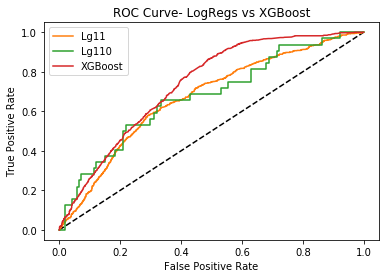

In [18]:
y1_pred_prob=model1.predict_proba(XSimple_test)[:,1]
y2_pred_prob=model2.predict_proba(XLarge_test)[:,1]
y3_pred_prob=model3.predict_proba(dfSimpleX_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr1, tpr1, thresholds1 = roc_curve(ySimple_test, y1_pred_prob)
fpr2, tpr2, thresholds2 = roc_curve(yLarge_test, y2_pred_prob)
fpr3, tpr3, thresholds3 = roc_curve(dfSimpley_test, y3_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1, tpr1,"C1",label="Lg11")
plt.plot(fpr2, tpr2,"C2",label="Lg110")
plt.plot(fpr3, tpr3,"C3",label="XGBoost")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- LogRegs vs XGBoost')
plt.legend()
plt.show()

<H3>Detalles de XGBoost</H3>

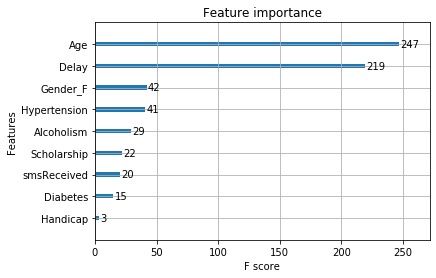

In [19]:
import xgboost
xgboost.plot_importance(model3, max_num_features=20)

<H3>Pruebas Varias</H3>

sc.stop()
conf = SparkConf().setAppName("App")
conf = (conf.setMaster('local[*]')
        .set('spark.executor.memory', '3G')
        .set('spark.driver.memory', '3G')
        .set('spark.driver.maxResultSize', '3G'))
sc = SparkContext(conf=conf)

<H2>Carga de Datos con Spark<H2>

In [ ]:
#"ALL", "DEBUG", "ERROR", "FATAL", "INFO", "OFF", "TRACE", "WARN"
sc.setLogLevel("INFO")
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch","80")

In [ ]:
sc._conf.getAll()

In [ ]:
#Carga del Modelo 'Abstract Base Table en un Spark DataFrame
#sp_dfSimple=spark.read.format("com.intersystems.spark").\
sp_dfSimple=spark.read.format("iris").\
option("url", "IRIS://iris4ml:51773/MLACADEMY").option("user", "SuperUser").\
option("password", "sys").\
option("query", "PublishedABT.MLSimpleAppointmentsGetfeatures()").load().limit(20000) 

In [ ]:
#Carga del Modelo 'Abstract Base Table en un Spark DataFrame
#sp_dfLarge=spark.read.format("com.intersystems.spark").\
sp_dfLarge=spark.read.format("iris").\
option("url", "IRIS://iris4ml:51773/MLACADEMY").option("user", "SuperUser").\
option("password", "sys").\
option("query", "PublishedABT.MLAppointmentsGetfeatures()").load().limit(20000) 

In [ ]:
#Mostrar las columnas de caracteristicas y la columna de resultado (Classification == Presente/Ausente) 
#sp_dfSimple.printSchema()
sp_dfLarge.printSchema()

In [ ]:
#spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch","50")

In [ ]:
# Enable Arrow-based columnar data transfers
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
# Convert the Spark DataFrame back to a Pandas DataFrame using Arrow
# ((Nota: requiere fechas como TimeStamp (no funciona bien con Dates) ))
dataSimple = sp_dfSimple.select("*").toPandas()
# data.drop(['ID'],axis=1,inplace=True)  #Eliminamos las columnas de ID, no sirven para determinar el resultado

In [ ]:
# Enable Arrow-based columnar data transfers
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
# Convert the Spark DataFrame back to a Pandas DataFrame using Arrow
# ((Nota: requiere fechas como TimeStamp (no funciona bien con Dates) ))
dataLarge = sp_dfLarge.select("*").toPandas()
# data.drop(['ID'],axis=1,inplace=True)  #Eliminamos las columnas de ID, no sirven para determinar el resultado